In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "hyper.10.02.ldcts"


In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
62,CN_ST18_GABA,2.935237e-07,1.874692e-07,0.058707,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Di...,1.231307
63,Endo,2.664876e-07,1.936492e-07,0.084390,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Di...,1.073710
64,ACx_MEIS2_GABA,1.960189e-06,1.521911e-06,0.098877,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Di...,1.004906
65,Microglia,1.634832e-07,1.338602e-07,0.110987,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Di...,0.954730
66,Lymphocyte,3.227474e-07,2.766427e-07,0.121674,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Di...,0.914801


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

2697    0.000457
992     0.000738
994     0.002222
993     0.002222
2698    0.002222
          ...   
1115    0.992736
2851    0.992736
495     0.995100
494     0.995100
1022    0.995100
Name: FDR_BH_corrected, Length: 589, dtype: float64


In [10]:
print(adj_pval.sort_values())

2697    0.000457
992     0.000738
2263    0.002222
1085    0.002257
2698    0.002270
          ...   
91      0.997727
3316    0.998231
3437    0.998448
988     0.998636
2386    0.999813
Name: adj_pval, Length: 589, dtype: float64


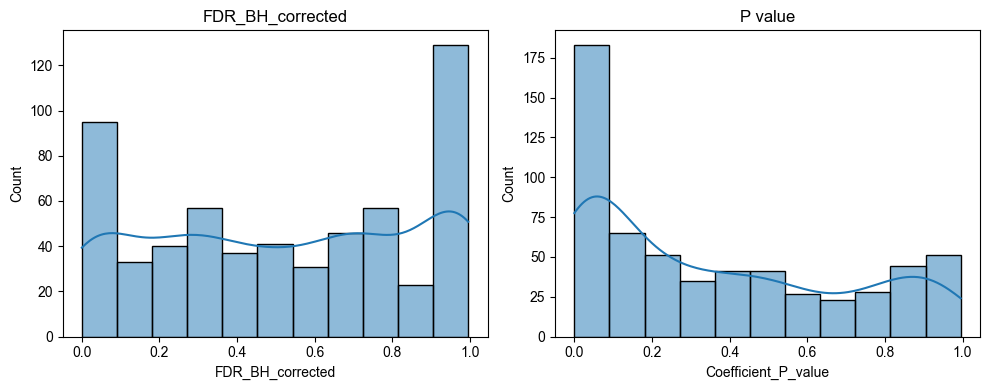

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.862362,0.122013,0.022698,0.527624,1.198501,0.486947,0.039486,0.940355,2.881891,1.464689,0.466481,1.567546,1.004906,0.733166,0.019587,0.703202,1.189703,1.217937,1.216600
Astrocyte,0.067176,1.249569,0.611648,0.307604,0.058711,0.407399,0.074333,0.728132,0.126218,0.002133,0.539756,0.534173,0.025946,0.006010,1.079123,0.057614,0.010549,0.062452,1.066533
CN_Cholinergic_GABA,0.223962,0.085337,0.010631,0.079685,1.614208,0.610703,1.092675,0.364302,1.782380,2.663987,0.236974,1.802831,0.676957,2.353835,0.240551,2.695361,1.863870,0.441342,1.573532
CN_GABA-Glut,1.025381,0.117350,0.010695,0.324404,1.095288,0.660592,0.476345,1.183389,1.713464,3.263982,0.340157,3.337584,0.227088,3.201030,0.269299,2.214541,1.522099,0.750253,0.891026
CN_LAMP5-CXCL14_GABA,1.834648,0.072907,0.077699,0.077633,3.885472,0.603413,0.357733,0.835344,4.109176,3.972621,0.933857,1.869250,0.359152,3.340140,0.438288,3.218678,1.613520,0.421178,0.373911


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.360534,0.934701,0.989740,0.567466,0.240593,0.597948,0.987390,0.328015,0.015879,0.165602,0.613423,0.142348,0.300198,0.433786,0.989740,0.447412,0.240855,0.234894,0.234894
Astrocyte,0.971871,0.230242,0.511193,0.738107,0.980043,0.658640,0.969231,0.435374,0.931185,0.995100,0.556652,0.560795,0.989740,0.992736,0.281692,0.980653,0.990359,0.975352,0.285502
CN_Cholinergic_GABA,0.806615,0.969231,0.990359,0.969231,0.132792,0.511193,0.277458,0.689112,0.098197,0.022400,0.793731,0.095375,0.462519,0.036730,0.791702,0.021597,0.086649,0.636288,0.141664
CN_GABA-Glut,0.291556,0.937761,0.990359,0.725965,0.277458,0.474685,0.607051,0.241327,0.111700,0.009181,0.713647,0.008482,0.803494,0.009506,0.761775,0.045493,0.151297,0.423804,0.347242
CN_LAMP5-CXCL14_GABA,0.090728,0.969231,0.969231,0.969231,0.003905,0.511938,0.691054,0.375782,0.003905,0.003905,0.331314,0.086512,0.691054,0.008482,0.636288,0.009506,0.132792,0.649201,0.684074


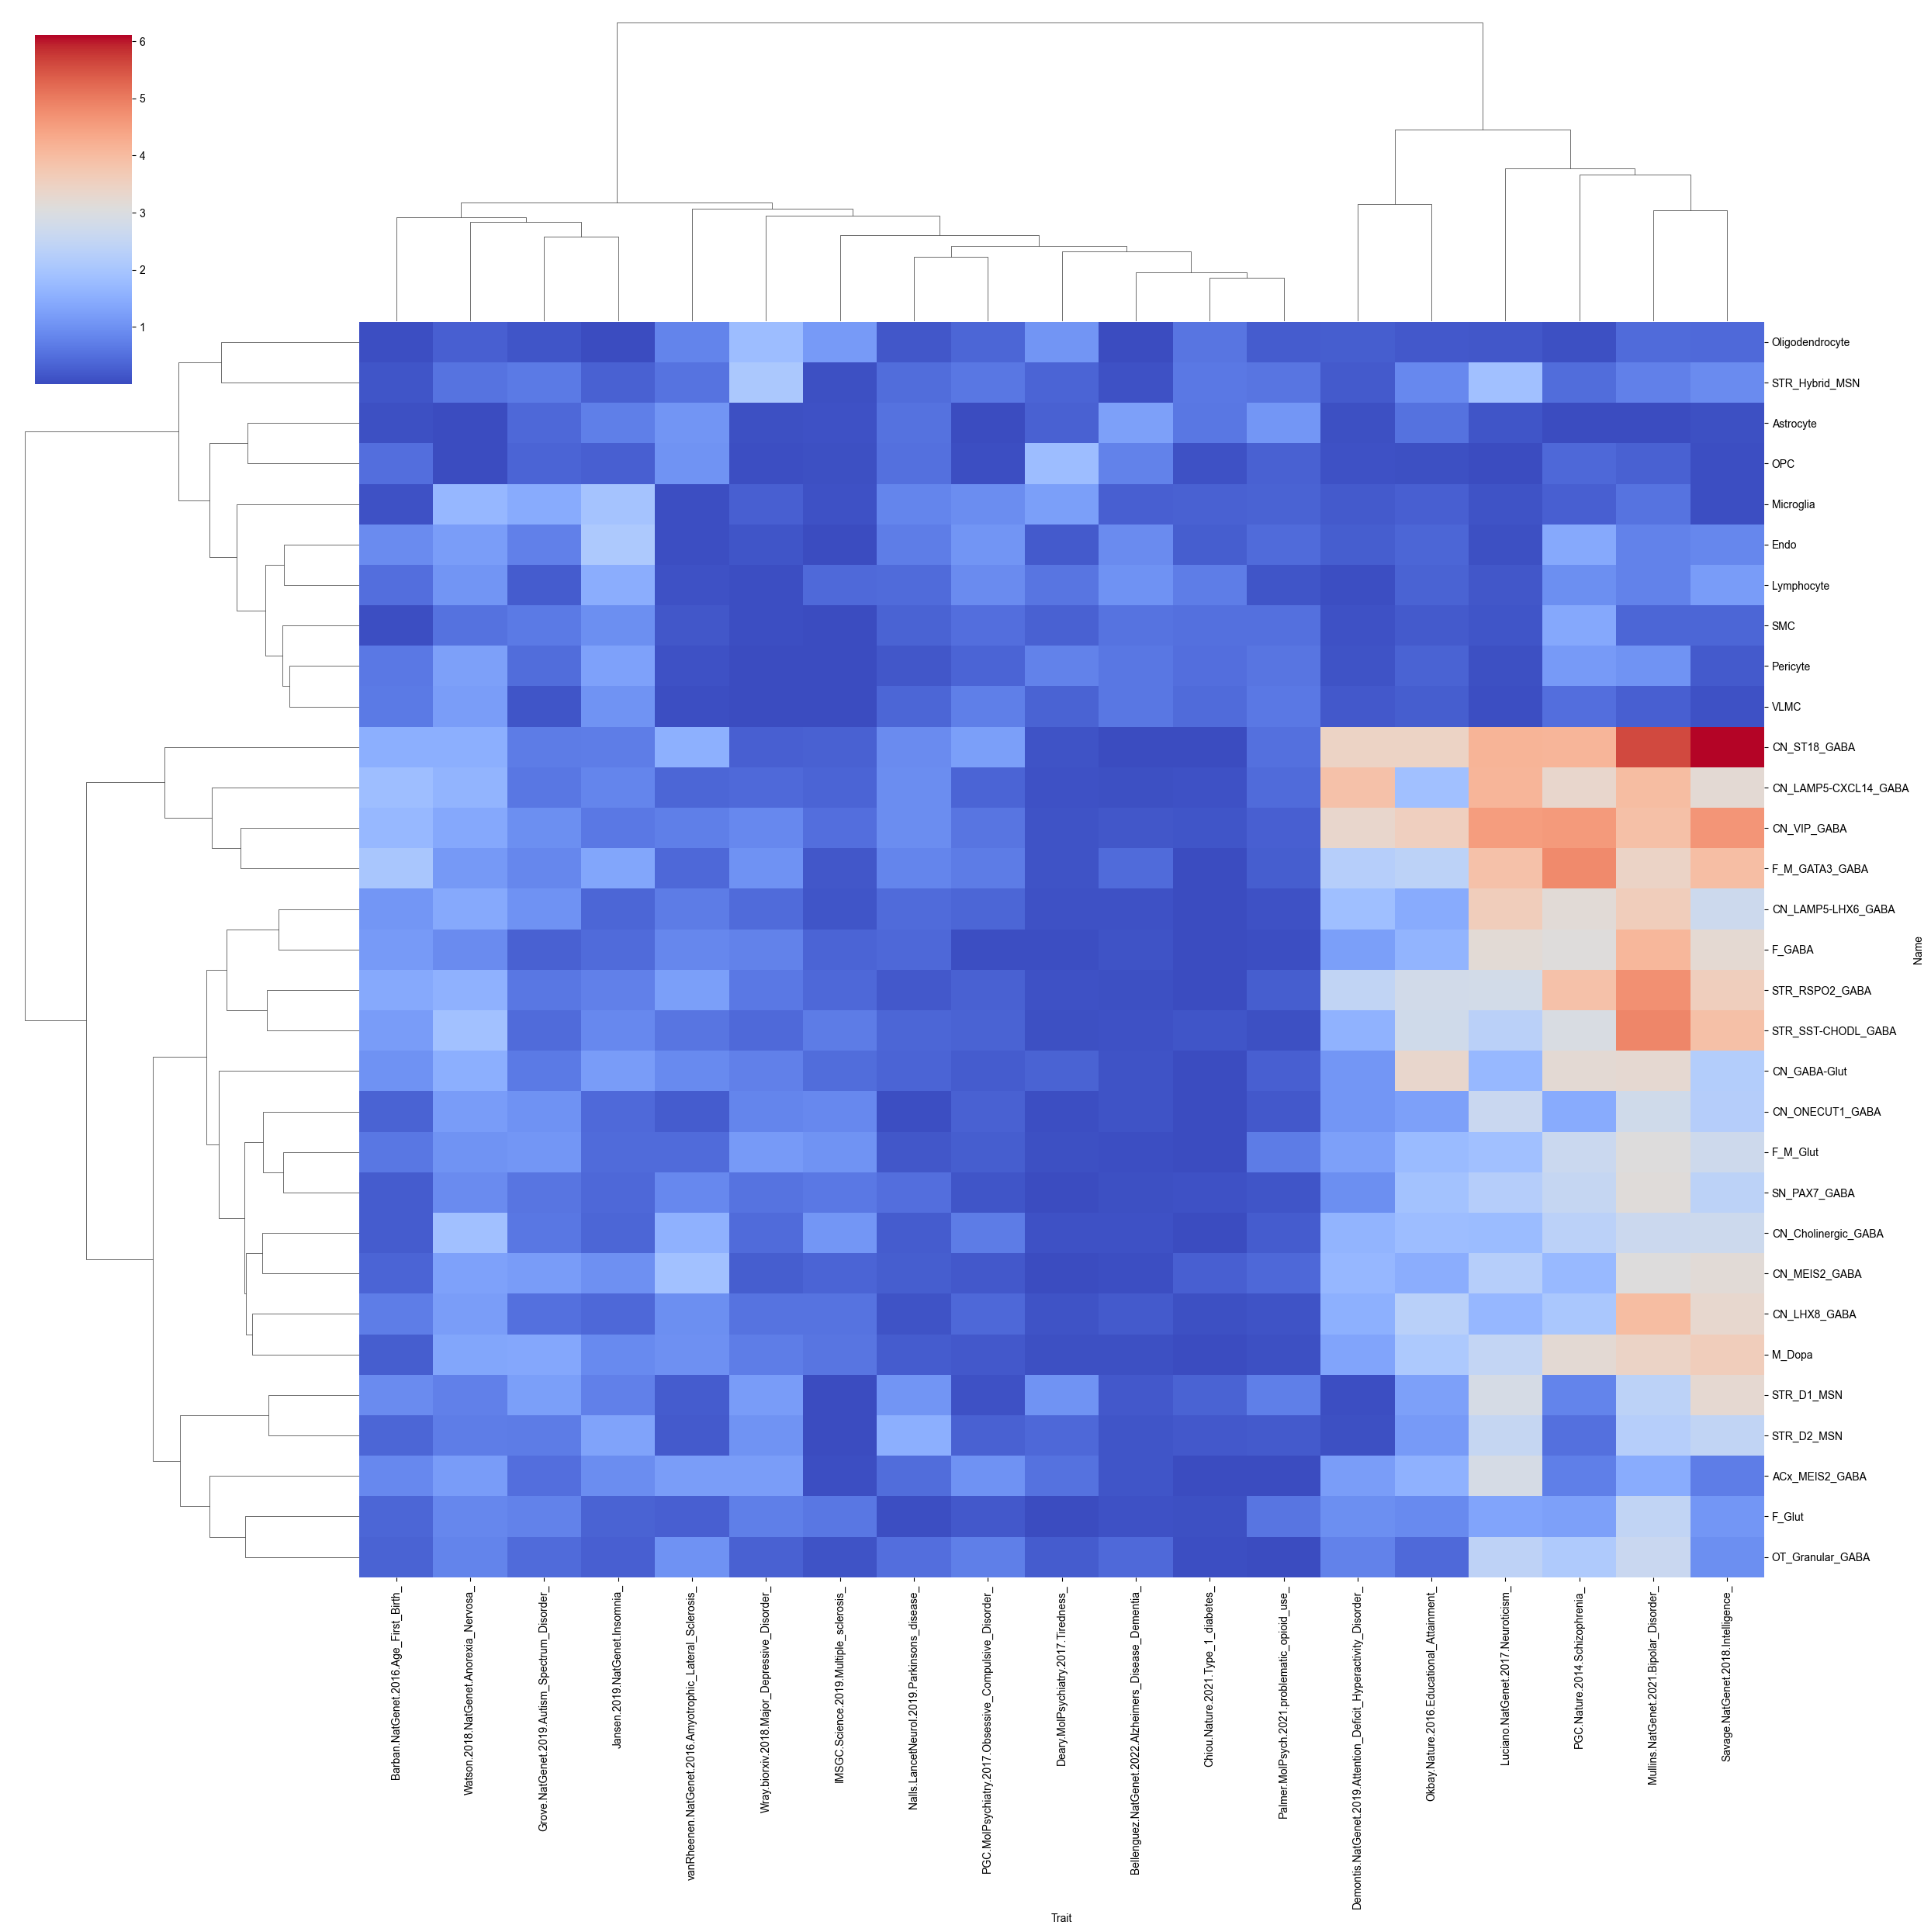

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
# g.savefig(f'output/{run_id}_filtered.pdf')

In [16]:
def pval_to_star(p):
    if p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [17]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [18]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [19]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['ADHD', 'Educational Attainment', 'Neuroticism', 'Schizophrenia',
       'Bipolar Disorder', 'Intelligence'],
      dtype='object', name='Trait')

In [20]:
# stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

# # Plot heatmap with annotations
# plt.figure(figsize=(25, 15))
# sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
# plt.title("-log10(pval) with FDR corrected p value stars")
# plt.tight_layout()
# plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
# plt.show()



In [22]:
import os
metadata = pd.read_csv(os.path.expanduser("~/Projects/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Subclass','Class','Neighborhood']].drop_duplicates().set_index('Subclass')
df_cols.sort_values(['Neighborhood','Class','Subclass'],inplace=True)
df_cols

,Class,Neighborhood
Subclass,,
F Glut,F M Glut,Glut Sero Dopa
F M Glut,F M Glut,Glut Sero Dopa
M Dopa,M Dopa,Glut Sero Dopa
Astrocyte,Astro-Epen,Nonneuron
Lymphocyte,Immune,Nonneuron
Microglia,Immune,Nonneuron
OPC,OPC-Oligo,Nonneuron
Oligodendrocyte,OPC-Oligo,Nonneuron
Endo,Vascular,Nonneuron


In [23]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

In [25]:
row_order

['F Glut',
 'F M Glut',
 'M Dopa',
 'Astrocyte',
 'Lymphocyte',
 'Microglia',
 'OPC',
 'Oligodendrocyte',
 'Endo',
 'Pericyte',
 'SMC',
 'VLMC',
 'CN LAMP5-CXCL14 GABA',
 'CN VIP GABA',
 'CN MEIS2 GABA',
 'OT Granular GABA',
 'STR D1 MSN',
 'STR D2 MSN',
 'STR Hybrid MSN',
 'CN Cholinergic GABA',
 'CN LAMP5-LHX6 GABA',
 'CN ST18 GABA',
 'STR RSPO2 GABA',
 'STR SST-CHODL GABA',
 'ACx MEIS2 GABA',
 'CN LHX8 GABA',
 'CN ONECUT1 GABA',
 'F GABA',
 'F M GATA3 GABA',
 'SN PAX7 GABA',
 'CN GABA-Glut']

['F Glut', 'F M Glut', 'M Dopa', 'Astrocyte', 'Lymphocyte', 'Microglia', 'OPC', 'Oligodendrocyte', 'Endo', 'Pericyte', 'SMC', 'VLMC', 'CN LAMP5-CXCL14 GABA', 'CN VIP GABA', 'CN MEIS2 GABA', 'OT Granular GABA', 'STR D1 MSN', 'STR D2 MSN', 'STR Hybrid MSN', 'CN Cholinergic GABA', 'CN LAMP5-LHX6 GABA', 'CN ST18 GABA', 'STR RSPO2 GABA', 'STR SST-CHODL GABA', 'ACx MEIS2 GABA', 'CN LHX8 GABA', 'CN ONECUT1 GABA', 'F GABA', 'F M GATA3 GABA', 'SN PAX7 GABA', 'CN GABA-Glut']


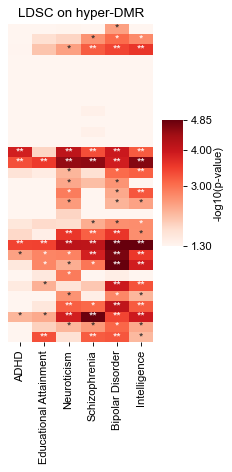

In [28]:
import os

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
print(row_order)
plt.figure(figsize=(3, 6))
ax=sns.heatmap(modified_df.loc[row_order,cols_to_keep], annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='Reds',cbar_kws={'shrink': 0.4,'fraction':0.12,'aspect':6},
               # annot_kws=dict(color='white',fontweight='bold'),
               vmin=1.3,vmax=4.85)
# plt.title("-log10(pval) with FDR corrected p value stars")
plt.title("LDSC on hyper-DMR")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.set_yticklabels([])
ax.tick_params(left=False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
cbar.set_ticks([1.3,3,4,4.85])
plt.tight_layout()
# plt.savefig(f'{run_id}_filtered_FDR.pdf')
plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/hyper_dmr.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()